# Gravity calibration revisited

previous gravity calibration had bad zipcodes and did ad-hoc linearization via logs. can we do better? it's also not extremely hard to take the gradient

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%cd ../..

/home/nick/Documents/4tb_sync/UVA GDrive/Summer 2022 (C4GC with BII)/measles_metapop


In [4]:
# vaccination data and population data from sifat
vacc_df = pd.read_csv("data/for_sim_opt_cleaned/pop.csv")
vacc_df

,id,pop,vacc
0,20007,1493,0.925653
1,20105,19750,0.920658
2,20106,3316,0.912847
3,20109,41198,0.916598
4,20110,44006,0.921306
...,...,...,...
700,24649,2875,0.912000
701,24651,7061,0.920125
702,24656,2913,0.917611
703,24657,711,0.902954


Clean and load VA commuting flow data

In [5]:
commuter = pd.read_excel('data/va_zipcodes_raw/commuting_flows_county_2015.xlsx',skiprows=6)

In [6]:
commuter.columns=['state_code1','county_code1','state_name1','county_name1',
                  'state_code2','county_code2','state_name2','county_name2',
                  'flow','error']
va_commuter = commuter[np.logical_and(commuter['state_name1'] == "Virginia",commuter['state_name2']=='Virginia')]\
    .reset_index(drop=True)
va_commuter = va_commuter[['county_name1','county_name2','flow','error']]
#va_commuter['county_name1'] = [' '.join([word for word in locality.split() if word.lower() not in ['county','city']]) for locality in va_commuter['county_name1']]
#va_commuter['county_name2'] = [' '.join([word for word in locality.split() if word.lower() not in ['county','city']]) for locality in va_commuter['county_name2']]
va_commuter['county_name1'] = ['_'.join([word.lower() for word in locality.split()]) for locality in va_commuter['county_name1']]
va_commuter['county_name2'] = ['_'.join([word.lower() for word in locality.split()]) for locality in va_commuter['county_name2']]
va_commuter.columns = ['from','to','flow','error']
va_commuter.head()

,from,to,flow,error
0,accomack_county,accomack_county,10922.0,634.0
1,accomack_county,chesterfield_county,9.0,17.0
2,accomack_county,fairfax_county,29.0,32.0
3,accomack_county,nelson_county,23.0,34.0
4,accomack_county,northampton_county,1318.0,243.0


In [7]:
dist_df = pd.read_csv("data/for_sim_opt_cleaned/dist.csv")
dist_mat = dist_df.pivot(index='zipcode1',columns='zipcode2',values='distKM')
dist_mat = dist_mat.replace(np.nan,0)

In [8]:
dist_mat

zipcode2,20007,20105,20106,20109,20110,20111,20112,20115,20117,20119,...,24634,24637,24639,24641,24646,24649,24651,24656,24657,37620
zipcode1,,,,,,,,,,,,,,,,,,,,,
20007,0.000000,43.488963,83.262415,40.631702,39.023633,36.538757,41.575859,70.911925,55.109462,57.021453,...,461.353950,458.052679,465.123640,461.996939,477.682064,474.192985,437.530881,479.154416,460.028904,520.202492
20105,43.488963,0.000000,46.458354,18.521859,22.051255,21.315067,31.223611,29.654972,12.057040,32.815535,...,422.709349,420.711943,427.469472,424.376509,439.428264,436.551620,400.445923,440.390433,421.637660,484.192890
20106,83.262415,46.458354,0.000000,42.685475,44.842012,47.110861,46.416076,19.581901,42.151872,29.888819,...,378.232756,375.423744,382.351761,379.239017,394.680508,391.429355,355.024094,396.007105,376.979047,438.361683
20109,40.631702,18.521859,42.685475,0.000000,3.982382,4.947951,12.788013,32.796616,27.706060,18.333408,...,420.727655,417.544749,424.575476,421.452465,437.077250,433.647499,397.057889,438.525230,419.414089,479.957266
20110,39.023633,22.051255,44.842012,3.982382,0.000000,2.590111,9.205262,36.190343,31.630453,18.382787,...,422.453164,419.035200,426.119492,422.991139,438.726763,435.187499,398.508390,440.269621,421.092536,481.214370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24649,474.192985,436.551620,391.429355,433.647499,435.187499,437.656154,434.022749,406.927877,428.723576,417.552936,...,25.329744,17.115617,9.082260,12.196787,13.535581,0.000000,37.994208,25.095341,21.539671,57.718890
24651,437.530881,400.445923,355.024094,397.057889,398.508390,400.995017,397.135039,370.875363,392.892280,380.755355,...,38.944431,20.973784,29.467177,26.324146,46.060306,37.994208,0.000000,53.525012,33.937869,85.821999
24656,479.154416,440.390433,396.007105,438.525230,440.269621,442.690487,439.618963,410.737866,432.050682,422.961111,...,17.950701,36.597144,27.694750,29.842534,11.639441,25.095341,53.525012,0.000000,20.700563,73.333259


`city_county_names`: removed Beford city (no longer independent as of 2013), inserted Greensville


Make the `agg_mapping` vector, which takes (index of zipcode) -> (index of county)

In [64]:
city_county_names = pd.read_csv('data/VA_zipcodes_cleaned/city_county_names_no_bedford_w_greensville.csv')
city_county_names = pd.read_csv('data/VA_zipcodes_cleaned/city_county_names_no_bedford_w_greensville_no_redundancies.csv')

In [65]:
agg_mapping = -np.ones(705)
geocoded_zips = pd.read_csv('data/VA_zipcodes_cleaned/VA_zips_latlong_nominatim.csv')

In [66]:
geocoded_zips['zipcode']

0      23086
1      23089
2      23092
3      23093
4      23102
       ...  
700    24053
701    24054
702    23060
703    23061
704    23608
Name: zipcode, Length: 705, dtype: int64

In [67]:
import copy

In [68]:
cities = ["Virginia Beach City", 
          "Norfolk City", 
          "Lynchburg City",
          "Danville City",
          "Alexandria City",
          "Hampton City", 
          "Poquoson City",
          "Newport News City",
          "Norton City",
          "Galax City",
          "Chesapeake City",
          "Harrisonburg City",
          "Staunton City",
          "Manassas City",
          "Manassas Park City",
          "Buena Vista City",
          "Winchester City",
          "Waynesboro City",
          "Emporia City",
          "Petersburg City",
          "Martinsville City",
          "Falls Church City",
          "Charlottesville City"
        "Colonial Heights City",
        "Covington City",
        "Franklin City",
        "Fredericksburg City",
        "Hopewell City",
        "Lexington City",
        "Richmond City",
        "Roanoke City"
         ]
allow_replace = ["fairfax city", "manassas park", "southampton", "northampton"]
#for zip_index, row in geocoded_zips.iterrows():
for zip_index, vacc_row in vacc_df.iterrows():
    row = geocoded_zips[geocoded_zips['zipcode'] == vacc_row['id']]
    info = row['display_name'].iloc[0]
    #print(info)
    skip = False
    set_once = False
    prev_set = ""
    for county_index, county_name in enumerate(city_county_names['name']):
        name_orig = copy.deepcopy(county_name)
        if county_name in cities:
            county_name = county_name.replace('City','').strip()
        county_name_processed = county_name.lower().split(' ')
        words_in_info = all([word in info.lower() for word in county_name_processed])
        if row['zipcode'].iloc[0] == 20175:
            agg_mapping[zip_index] = city_county_names[city_county_names['name'] == "Loudoun"].index[0]
            skip=True
            set_once=True
        elif row['zipcode'].iloc[0] == 20176:
            agg_mapping[zip_index] = city_county_names[city_county_names['name'] == "Loudoun"].index[0]
            skip=True
            set_once=True
        elif row['zipcode'].iloc[0] == 24066:
            agg_mapping[zip_index] = city_county_names[city_county_names['name'] == "Botetourt"].index[0]
            skip=True
            set_once=True
        elif row['zipcode'].iloc[0] == 22747:
            agg_mapping[zip_index] = city_county_names[city_county_names['name'] == "Rappahannock"].index[0]
            skip=True
            set_once=True
        elif row['zipcode'].iloc[0] == 23075:
            agg_mapping[zip_index] = city_county_names[city_county_names['name'] == "Henrico"].index[0]
            skip=True
            set_once=True
        elif row['zipcode'].iloc[0] in [22460,22572]:
            agg_mapping[zip_index] = city_county_names[city_county_names['name'] == "Richmond"].index[0]
            skip=True
            set_once=True
        elif row['zipcode'].iloc[0] in [23219,23220,23221,23222,23224,23225]:
            agg_mapping[zip_index] = city_county_names[city_county_names['name'] == "Richmond City"].index[0]
            skip=True
            set_once=True
        elif row['zipcode'].iloc[0] in [23851]:
            agg_mapping[zip_index] = city_county_names[city_county_names['name'] == "Franklin City"].index[0]
            skip=True
            set_once=True
        elif row['zipcode'].iloc[0] in [24065,24067, 24088, 24092, 24101, 24102,24137, 24151, 24176, 24184]:
            agg_mapping[zip_index] = city_county_names[city_county_names['name'] == "Franklin"].index[0]
            skip=True
            set_once=True
        elif row['zipcode'].iloc[0] in [24012,24013,24014,24015,24016,24017]:
            agg_mapping[zip_index] = city_county_names[city_county_names['name'] == "Roanoke City"].index[0]
            skip=True
            set_once=True
        elif row['zipcode'].iloc[0] in [24018,24019,24059]:
            agg_mapping[zip_index] = city_county_names[city_county_names['name'] == "Roanoke"].index[0]
            skip=True
            set_once=True
        elif row['zipcode'].iloc[0] in [22401]:
            agg_mapping[zip_index] = city_county_names[city_county_names['name'] == "Fredericksburg City"].index[0]
            skip=True
            set_once=True
        elif row['zipcode'].iloc[0] in [22902,22903]:
            agg_mapping[zip_index] = city_county_names[city_county_names['name'] == "Charlottesville City"].index[0]
            skip=True
            set_once=True
        if words_in_info and not set_once and not skip:
            city_county_names['name'] == county_name
            agg_mapping[zip_index] = county_index
            set_once = True
            prev_set = county_name
        elif words_in_info and set_once and county_name.lower() in allow_replace:
            city_county_names['name'] == county_name
            agg_mapping[zip_index] = county_index
            set_once = True
            prev_set = county_name
        elif words_in_info and set_once and prev_set != "":
            print('tried to assign',row['zipcode'].iloc[0],'twice:')
            print('  already set as',prev_set)
            print('  tried to set to',name_orig)
            print('  ' +info)
    if set_once == False:
        print(info)
agg_mapping = np.int64(agg_mapping)

tried to assign 22042 twice:
  already set as Fairfax
  tried to set to Falls Church City
  West Falls Church, Fairfax County, Virginia, 22042, United States


Save the `agg_mapping` array as a csv

In [69]:
pd.Series(agg_mapping,name='mapping').to_csv('data/for_sim_opt_cleaned/agg_mapping.csv', index=False)

Display `agg_mapping` csv

In [72]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(
        pd.DataFrame(
            {'display':
             [geocoded_zips[geocoded_zips['zipcode'] == z]['display_name'].iloc[0] for z in vacc_df['id']], 
             'agg':
             [city_county_names['name'][i] for i in agg_mapping]}
        ).sort_values('agg')
    )

,display,agg
357,"Accomack County, Virginia, 23442, United States",Accomack
321,"Accomack County, Virginia, 23306, United States",Accomack
322,"Accomack County, Virginia, 23308, United States",Accomack
332,"Chincoteague, Accomack County, Virginia, 23336...",Accomack
335,"Accomack County, Virginia, 23357, United States",Accomack
336,"Accomack County, Virginia, 23359, United States",Accomack
337,"Accomack County, Virginia, 23389, United States",Accomack
320,"Accomack County, Virginia, 23301, United States",Accomack
339,"Accomack County, Virginia, 23409, United States",Accomack
368,"Accomack County, Virginia, 23488, United States",Accomack


In [73]:
x = [23,
27,
28,
44,
46,
61,
69,
105,
107,
121]

x= [27,
28,
61,
69,
121]

for index in x:
    print(city_county_names.loc[index,'name'])


Craig
Culpeper
King And Queen
Lynchburg City
Waynesboro City


In [74]:
for index,row in geocoded_zips.iterrows():
    if "Sussex" in row['display_name']:
        print(row['display_name'])

Construct `inv_agg_mapping`: takes (index of county) -> (list of indices of zipcodes contained in that county)

In [32]:
# county -> [list of zipcodes]
inv_agg_mapping = []
for i in range(len(city_county_names.index)):
    zipcodes = []
    for index,j in enumerate(agg_mapping):
        if i==j: zipcodes.append(index)
    inv_agg_mapping.append(zipcodes)

Dictionary that maps county names to county indices

In [33]:
county_name_index = {}
for index,name in enumerate(city_county_names['name']):
    this_name = name.lower()
    if 'charles' in this_name:
        result = '_'.join([word.lower() for word in (name+" county").split()])
    elif 'james' in this_name:
        result = '_'.join([word.lower() for word in (name+" county").split()])
    elif 'city' in this_name:
        result = '_'.join([word.lower() for word in name.split()])
    elif this_name == 'bristol':
        result = '_'.join([word.lower() for word in (name+" city").split()])
    elif this_name == 'radford':
        result = '_'.join([word.lower() for word in (name+" city").split()])
    elif this_name == 'salem':
        result = '_'.join([word.lower() for word in (name+" city").split()])
    else:
        result = '_'.join([word.lower() for word in (name+" county").split()])
    county_name_index[result]=index

Set up functions to compute gravity model, predict, and compute the MSE of predictions

In [34]:
from scripts.spatial_tsir import *

In [20]:
def grav_mod(distances,population,tau1,tau2,rho,theta):
    params = {"tau1":tau1, "tau2":tau2, "rho":rho, "theta":theta}
    # if I is replaced by N, it should be equivalent.
    return gravity(population,distances,np.array(population['pop']),params,variant='orig')

In [35]:
def grav_agg(tau1,tau2,rho,theta, agg_mapping):
    matrix,influx = gravity_numba(
        np.array(vacc_df['pop']),
        np.array(dist_mat),
        np.array(vacc_df['pop']),
        tau1,tau2,rho,theta,
        variant="orig"
    )
    agg_size = np.max(agg_mapping)+1
    agg_flows = np.zeros((agg_size,agg_size))
    matrix_size = np.shape(matrix)[0]
    for i in range(matrix_size):
        for j in range(matrix_size):
            agg_flows[ agg_mapping[i], agg_mapping[j] ] += matrix[i,j]
            
    return agg_flows

In [51]:
def grav_agg(tau1,tau2,rho,theta, phi, agg_mapping):
    matrix,influx = gravity_numba(
        np.array(vacc_df['pop']),
        np.array(dist_mat),
        np.array(vacc_df['pop']),
        tau1,tau2,rho,theta, phi,
        variant="orig_additive"
    )
    agg_size = np.max(agg_mapping)+1
    agg_flows = np.zeros((agg_size,agg_size))
    matrix_size = np.shape(matrix)[0]
    for i in range(matrix_size):
        for j in range(matrix_size):
            agg_flows[ agg_mapping[i], agg_mapping[j] ] += matrix[i,j]
            
    return agg_flows

In [52]:
grav_agg(1,2.3,1,1e-10,1,agg_mapping)

array([[ 550997.67361798,  421534.36687164,  163247.56287208, ...,
         194437.70771673,  194436.45475192,  162572.28149691],
       [1404675.84149157,  946805.36031051,  393568.07177997, ...,
         468316.83274172,  468327.72321135,  390806.96507458],
       [2019839.59477474, 1460535.65015245,  576508.91194529, ...,
         673364.85483031,  673361.42480493,  562014.98680417],
       ...,
       [ 690017.58848591,  498581.62100896,  192145.03443459, ...,
         192504.03098447,  230109.86057586,  191787.33161564],
       [ 466780.80345661,  337354.64920097,  130074.88856441, ...,
         155686.37092785,  129960.84776601,  129765.48921775],
       [ 940728.26434311,  679982.5040433 ,  263061.16874256, ...,
         313607.04280734,  313606.70425731,  217655.92546952]])

In [37]:
def mse(agg_grav_flows, commuter_flows, county_name_index, return_unlisted=False, error_type="mse"):
    error = 0
    n = np.shape(agg_grav_flows)[0]
    unlisted_localities = []
    for index,row in commuter_flows.iterrows():
        try:
            from_index = county_name_index[row['from']]
        except KeyError:
            if not row['from'] in unlisted_localities:
                unlisted_localities.append(row['from'])
            continue
        try:
            to_index = county_name_index[row['to']]
        except KeyError:
            if not row['to'] in unlisted_localities:
                unlisted_localities.append(row['to'])
            continue
        if error_type == "mse":
            error += (agg_grav_flows[from_index,to_index] - row['flow'])**2
        elif error_type == "abs":
            error += agg_grav_flows[from_index,to_index] - row['flow']
    error = error/(2*n)
    if return_unlisted:
        return unlisted_localities,error
    else:
        return error

In [38]:
def predict(agg_grav_flows, commuter_flows, county_name_index):
    n = np.shape(agg_grav_flows)[0]
    unlisted_localities = []
    data = []
    preds = []
    for index,row in commuter_flows.iterrows():
        try:
            from_index = county_name_index[row['from']]
        except KeyError:
            if not row['from'] in unlisted_localities:
                unlisted_localities.append(row['from'])
            continue
        try:
            to_index = county_name_index[row['to']]
        except KeyError:
            if not row['to'] in unlisted_localities:
                unlisted_localities.append(row['to'])
            continue
        preds.append(agg_grav_flows[from_index,to_index])
        data.append(row['flow'])
    return np.array(preds), np.array(data)

In [45]:
#2.05129753,   1.00658477,   1.39756793, -22.51557032
preds, data = predict(grav_agg(2.05129753,   1.00658477,   1.39756793, np.exp(-22.51557032),agg_mapping), va_commuter, county_name_index)

In [39]:
mse(grav_agg(7.91523059e-01, 1.17685482e-02, 1.27603521e+00,1,agg_mapping), va_commuter, county_name_index)

207207051.58108145

In [27]:
mse(grav_agg(1, 1, 1,1e-10,agg_mapping), va_commuter, county_name_index)

794016271.5394746

In [28]:
mse(grav_agg(1.2, 0.7, 1,1e-10,agg_mapping), va_commuter, county_name_index)

794018358.503252

In [29]:
np.linspace(1e-10,1)

array([1.00000000e-10, 2.04081634e-02, 4.08163266e-02, 6.12244899e-02,
       8.16326532e-02, 1.02040816e-01, 1.22448980e-01, 1.42857143e-01,
       1.63265306e-01, 1.83673469e-01, 2.04081633e-01, 2.24489796e-01,
       2.44897959e-01, 2.65306123e-01, 2.85714286e-01, 3.06122449e-01,
       3.26530612e-01, 3.46938776e-01, 3.67346939e-01, 3.87755102e-01,
       4.08163265e-01, 4.28571429e-01, 4.48979592e-01, 4.69387755e-01,
       4.89795918e-01, 5.10204082e-01, 5.30612245e-01, 5.51020408e-01,
       5.71428571e-01, 5.91836735e-01, 6.12244898e-01, 6.32653061e-01,
       6.53061225e-01, 6.73469388e-01, 6.93877551e-01, 7.14285714e-01,
       7.34693878e-01, 7.55102041e-01, 7.75510204e-01, 7.95918367e-01,
       8.16326531e-01, 8.36734694e-01, 8.57142857e-01, 8.77551020e-01,
       8.97959184e-01, 9.18367347e-01, 9.38775510e-01, 9.59183673e-01,
       9.79591837e-01, 1.00000000e+00])

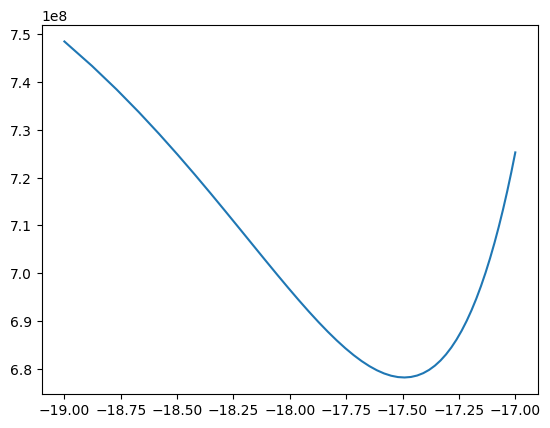

In [30]:
thetas_to_try = np.linspace(np.exp(-19),np.exp(-17))
#mses = [mse(grav_agg(7.91523059e-01, 1.17685482e-02, 1.27603521e+00,thet,agg_mapping), va_commuter, county_name_index) for thet in thetas_to_try]
#[  1.3704949 ,   1.36992368,   1.99993131, -15.00000132]

mses = [mse(grav_agg(1.3704949 ,   1.36992368,   1.99993131,thet,agg_mapping), va_commuter, county_name_index) for thet in thetas_to_try]
plt.plot(np.log(thetas_to_try), mses)

In [31]:
def grav_jacobian(tau1,tau2,rho,theta, pop,dist_mat, agg_mapping,inv_agg_mapping, commuter_flows, scale=False):
    matrix,influx = gravity_numba(
        np.array(vacc_df['pop']),
        np.array(dist_mat),
        np.array(vacc_df['pop']),
        tau1,tau2,rho,theta
    )
    agg_size = np.max(agg_mapping)+1
    agg_flows = np.zeros((agg_size,agg_size))
    matrix_size = np.shape(matrix)[0]
    for i in range(matrix_size):
        for j in range(matrix_size):
            agg_flows[ agg_mapping[i], agg_mapping[j] ] += matrix[i,j]
    
    residuals = []
    partial_theta = []
    partial_tau1 = []
    partial_tau2 = []
    partial_rho = []
    pred = []
    data = []
    n = len(commuter_flows.index)
    for index,row in commuter_flows.iterrows():
        try:
            from_index = county_name_index[row['from']]
            to_index = county_name_index[row['to']]
        except KeyError:
            continue
        residuals.append(agg_flows[from_index,to_index] - row['flow'])
        pred.append(agg_flows[from_index,to_index])
        data.append(row['flow'])
        partial_theta.append((1/theta)*agg_flows[from_index,to_index])

        grav_unsummed = []
        tau1_pop_logs = []
        tau2_pop_logs = []
        rho_factor = []
        for zip_index_from in inv_agg_mapping[county_name_index[row['from']]]:
            for zip_index_to in inv_agg_mapping[county_name_index[row['to']]]:
                if zip_index_from == zip_index_to:
                    continue
                grav_unsummed.append(
                    theta*(pop[zip_index_from]**tau1 * pop[zip_index_to]**tau2)/dist_mat[zip_index_from, zip_index_to]**rho
                )
                tau1_pop_logs.append(
                    np.log(pop[zip_index_from])
                )
                tau2_pop_logs.append(
                    np.log(pop[zip_index_to])
                )
                rho_factor.append(
                    -np.log(dist_mat[zip_index_from, zip_index_to])/dist_mat[zip_index_from, zip_index_to]**rho
                )
        partial_tau1.append(np.array(grav_unsummed) @ np.array(tau1_pop_logs))
        partial_tau2.append(np.array(grav_unsummed) @ np.array(tau2_pop_logs))
        partial_rho.append(np.array(grav_unsummed) @ np.array(rho_factor))
    
    jac= np.array([
        (1/n)* np.array(residuals) @ np.array(partial_tau1),
        (1/n)* np.array(residuals) @ np.array(partial_tau2),
        (1/n)* np.array(residuals) @ np.array(partial_rho),
        (1/n)* np.array(residuals) @ np.array(partial_theta)
    ])
    if scale:
        jac = jac/np.linalg.norm(jac,ord=2)
    return jac

In [38]:
def grav_jacobian(tau1,tau2,rho,log_theta, pop,dist_mat, agg_mapping,inv_agg_mapping, commuter_flows, scale=False, return_data = False):
    matrix,influx = gravity_numba(
        np.array(vacc_df['pop']),
        np.array(dist_mat),
        np.array(vacc_df['pop']),
        tau1,tau2,rho,np.exp(log_theta)
    )
    agg_size = np.max(agg_mapping)+1
    agg_flows = np.zeros((agg_size,agg_size))
    matrix_size = np.shape(matrix)[0]
    for i in range(matrix_size):
        for j in range(matrix_size):
            agg_flows[ agg_mapping[i], agg_mapping[j] ] += matrix[i,j]
    
    residuals = []
    partial_theta = []
    partial_tau1 = []
    partial_tau2 = []
    partial_rho = []
    pred = []
    data = []
    n = len(commuter_flows.index)
    for index,row in commuter_flows.iterrows():
        try:
            from_index = county_name_index[row['from']]
            to_index = county_name_index[row['to']]
        except KeyError:
            continue
        residuals.append(agg_flows[from_index,to_index] - row['flow'])
        pred.append(agg_flows[from_index,to_index])
        data.append(row['flow'])
        partial_theta.append(np.exp(log_theta)*agg_flows[from_index,to_index])

        grav_unsummed = []
        tau1_pop_logs = []
        tau2_pop_logs = []
        rho_factor = []
        for zip_index_from in inv_agg_mapping[county_name_index[row['from']]]:
            for zip_index_to in inv_agg_mapping[county_name_index[row['to']]]:
                if zip_index_from == zip_index_to:
                    continue
                grav_unsummed.append(
                    np.exp(log_theta)*(pop[zip_index_from]**tau1 * pop[zip_index_to]**tau2)/dist_mat[zip_index_from, zip_index_to]**rho
                )
                tau1_pop_logs.append(
                    np.log(pop[zip_index_from])
                )
                tau2_pop_logs.append(
                    np.log(pop[zip_index_to])
                )
                rho_factor.append(
                    -np.log(dist_mat[zip_index_from, zip_index_to])/dist_mat[zip_index_from, zip_index_to]**rho
                )
        partial_tau1.append(np.array(grav_unsummed) @ np.array(tau1_pop_logs))
        partial_tau2.append(np.array(grav_unsummed) @ np.array(tau2_pop_logs))
        partial_rho.append(np.array(grav_unsummed) @ np.array(rho_factor))
    
    jac= np.array([
        (1/n)* np.array(residuals) @ np.array(partial_tau1),
        (1/n)* np.array(residuals) @ np.array(partial_tau2),
        (1/n)* np.array(residuals) @ np.array(partial_rho),
        (1/n)* np.array(residuals) @ np.array(partial_theta)
    ])
    if scale:
        jac = jac/np.linalg.norm(jac,ord=2)
    if return_data:
        return jac, data, pred
    return jac

In [109]:
jac,data,preds = grav_jacobian(   0.02775402, 0.1054099 , 1.27194855, 8.01293423,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter,return_data=True)
#jac, data, preds = grav_jacobian(2.2, 0.8, 1.6, 3.7300000000e-11,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)

In [420]:
jac,data,preds = grav_jacobian(  0.94003839,   1.50230616,   1.01726248, -16.,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter,return_data=True)
#jac, data, preds = grav_jacobian(2.2, 0.8, 1.6, 3.7300000000e-11,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)

In [126]:
9.08568126e-03,  7.52489127e-02,  1.24525737e+00, -1.59999986e+01

jac,data,preds = grav_jacobian(9.08568126e-03,  7.52489127e-02,  1.24525737e+00, -1.59999986e+01,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter,return_data=True)
#jac, data, preds = grav_jacobian(2.2, 0.8, 1.6, 3.7300000000e-11,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)

(array([4.00e+00, 0.00e+00, 5.00e+00, 3.24e+03, 2.36e+02, 3.10e+01,
        7.00e+00, 2.00e+00, 3.00e+00, 3.00e+00]),
 array([-36524.67100034, -27115.3652278 , -17706.05945525,  -8296.75368271,
          1112.55208983,  10521.85786238,  19931.16363492,  29340.46940747,
         38749.77518001,  48159.08095256,  57568.3867251 ]),
 <BarContainer object of 10 artists>)

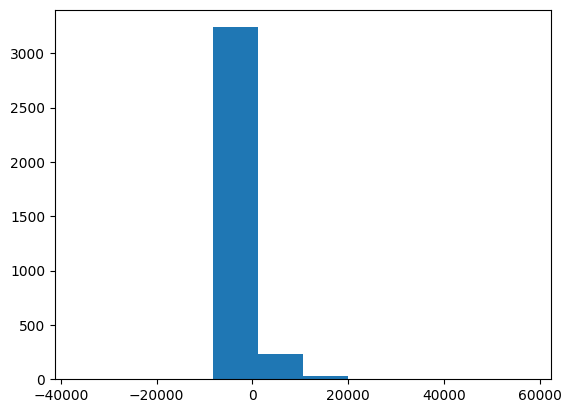

In [46]:
plt.hist(np.array(data)-np.array(preds))

In [107]:
mse(grav_agg(0.02775402, 0.1054099 , 1.27194855, np.exp(8.01293423),agg_mapping), va_commuter, county_name_index)

535320153.58087206

In [206]:
 mse(grav_agg(9.08568126e-03,  7.52489127e-02,  1.24525737e+00, np.exp(-1.59999986e+01),agg_mapping), va_commuter, county_name_index)
    
    

794019591.310245

In [274]:
mse(grav_agg(0.45165793,  0.55593515,  1.08838145, np.exp(-1),agg_mapping), va_commuter, county_name_index)

559007201.9033873

In [268]:
jac,data,preds = grav_jacobian(   0.45165793,  0.55593515,  1.08838145, -1,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter,return_data=True)
#jac, data, preds = grav_jacobian(2.2, 0.8, 1.6, 3.7300000000e-11,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)

In [261]:
jac,data,preds = grav_jacobian(  0.49021528,  0.59571512,  1.07962668, -1,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter,return_data=True)
#jac, data, preds = grav_jacobian(2.2, 0.8, 1.6, 3.7300000000e-11,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)

In [334]:

jac,data,preds = grav_jacobian(  0.61864165,  0.775458  ,  1.05476762, -5  ,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter,return_data=True)
#jac, data, preds = grav_jacobian(2.2, 0.8, 1.6, 3.7300000000e-11,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)

In [346]:
jac,data,preds = grav_jacobian(  0.11305425,   2.70493699,   1.17009179, -20.17881369  ,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter,return_data=True)
#jac, data, preds = grav_jacobian(2.2, 0.8, 1.6, 3.7300000000e-11,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)


In [451]:
0.79281278,   1.08151774,   1.03411713, -10.    
jac,data,preds = grav_jacobian( 1,   1.1151774,   0.951713, -10.       ,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter,return_data=True)
#jac, data, preds = grav_jacobian(2.2, 0.8, 1.6, 3.7300000000e-11,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)


In [476]:
0.79281278,   1.08151774,   1.03411713, -10.    
jac,data,preds = grav_jacobian( 0.83439332,   1.02912974,   0.98879558, -10     ,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter,return_data=True)
#jac, data, preds = grav_jacobian(2.2, 0.8, 1.6, 3.7300000000e-11,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)
#jac,data,preds = grav_jacobian( 0.8739332,   1.02912974,   0.98879558, -9.5 ,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter,return_data=True)



In [500]:
0.08658264,   2.95947255,   1.0884192 , -23.   
jac,data,preds = grav_jacobian( 0.10658264,   2.95947255,   1.0884192 , -23   ,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter,return_data=True)
#jac,data,preds = grav_jacobian( 0.10658264,   2.95947255,   1.0884192 , -22.3   ,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter,return_data=True)
#jac, data, preds = grav_jacobian(2.2, 0.8, 1.6, 3.7300000000e-11,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)


In [503]:
(1/len(preds))*np.sum(np.abs(np.array(preds)-np.array(data)))

1518.112720982411

In [504]:
from sklearn.metrics import mean_squared_error
mean_squared_error(data,preds)

49800182.9635495

In [48]:
np.corrcoef(preds,data)

array([[1.        , 0.91374264],
       [0.91374264, 1.        ]])

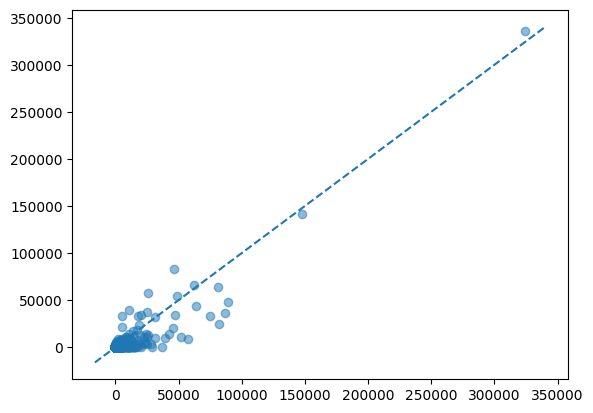

In [50]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(data,preds,alpha=0.5)
axes = plt.gca()
#axes.set_xlim([-10,1000])
#axes.set_ylim([-10,1000])
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
abline(1,0)



In [282]:
def abs_err(tau1 , tau2,   rho, log_theta,pop, dist_mat,agg_mapping,inv_agg_mapping,va_commuter):
    jac,data,preds = grav_jacobian(   tau1, tau2 , rho, log_theta,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter,return_data=True)
    return (1/len(pop))*np.sum(np.abs(np.array(data)-np.array(preds)))

abs_err( 1.3 ,   1.3,   1.3, -16.,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)

12880.644605797228

In [267]:
abs_err( 0.49021528,  0.59571512,  1.07962668, -1,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)

15570.170608392787

In [273]:
abs_err( 0.45165793,  0.55593515,  1.08838145, -1,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)

9045.957094832771

In [288]:
abs_err(1.8413476 ,   1.8413476 ,   0.96471132, -30.   ,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)

5971.912370131604

In [ ]:
gradient, residuals = grav_jacobian(2.2, .796, 1.56, 3.73e-10,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)

In [ ]:
import seaborn as sns
sns.kdeplot(residuals)

In [284]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -30]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None)
    ]
)

/tmp/ipykernel_12908/3882040422.py:3: RuntimeWarning: overflow encountered in exp
  fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),


      fun: 705784815.4850378
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.94766513e+08, -5.96118168e+08,  1.40250909e+08, -5.80247116e+07])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 50
      nit: 2
     njev: 10
   status: 0
  success: True
        x: array([  1.8413476 ,   1.8413476 ,   0.96471132, -30.        ])

In [337]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1.87019977e-02,  2.96937896e+00,  1.00326036e+00, -2.018307900e+01 ]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,-10)
    ]
)

      fun: 596705492.6376479
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.19209289e+01,  1.66893006e+02,  1.19209290e+01, -4.30391991e+06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 340
      nit: 45
     njev: 68
   status: 0
  success: True
        x: array([  0.79281278,   1.08151774,   1.03411713, -10.        ])

In [345]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1.87019977e-02,  2.96937896e+00,  1.00326036e+00, -2.018307900e+01 ]),
    method = "TNC",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,-15)
    ]
)

     fun: 646669382.5364685
     jac: array([-3146243.09705399, 20491051.79842293, -8408582.26164369,
       -2077674.69381508])
 message: 'Max. number of function evaluations reached'
    nfev: 505
     nit: 13
  status: 3
 success: False
       x: array([  0.11305425,   2.70493699,   1.17009179, -20.17881369])

In [404]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1.87019977e-02,  2.96937896e+00,  1.00326036e+00, -2.318307900e+01 ]),
    method = "TNC",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,-23)
    ]
)

     fun: 660015299.5108368
     jac: array([-1.91268492e+08, -1.84200121e+08,  2.57337691e+07, -2.06258757e+07])
 message: 'Max. number of function evaluations reached'
    nfev: 505
     nit: 15
  status: 3
 success: False
       x: array([  0.08658264,   2.95947255,   1.0884192 , -23.        ])

In [ ]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1.87019977e-02,  2.96937896e+00,  1.00326036e+00, -2.018307900e+01 ]),
    method = "TNC",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,-15)
    ]
)

In [372]:
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array( [0.9,   1.1151774,   0.911713, -10. ]),
    method = "TNC",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,-10)
    ]
)

     fun: 596902571.3308231
     jac: array([-1079869.26489862, -1684594.16459598, -7720828.01754015,
       -4410576.4554408 ])
 message: 'Max. number of function evaluations reached'
    nfev: 505
     nit: 17
  status: 3
 success: False
       x: array([  0.83439332,   1.02912974,   0.98879558, -10.        ])

In [ ]:

    
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array( [2,   2 ,   1.5, -30.]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,-5)
    ]
)

In [129]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1.3, 1.3, 1.3, -10]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,-10)
    ]
)

      fun: 596705492.6423522
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.40018079e+03, -5.07831577e+03,  1.21593476e+03, -4.30462325e+06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 270
      nit: 44
     njev: 54
   status: 0
  success: True
        x: array([  0.79279475,   1.08153532,   1.0341167 , -10.        ])

In [130]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1.3, 1.3, 1.3, -15]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,-15)
    ]
)

      fun: 618248287.4034325
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.81469725e+02, -9.53674322e+01, -1.06096268e+03, -4.29756606e+06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 165
      nit: 26
     njev: 33
   status: 0
  success: True
        x: array([  0.92219922,   1.42621468,   1.02001724, -15.        ])

In [ ]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1.3, 1.3, 1.3, -15]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,-15)
    ]
)

In [131]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1.3, 1.3, 1.3, -20]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,-20)
    ]
)

      fun: 639489682.1723955
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.19209289e+02,  8.34465032e+01,  9.53674322e+01, -4.17609180e+06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 185
      nit: 23
     njev: 37
   status: 0
  success: True
        x: array([  0.97416952,   1.84102233,   1.00797096, -20.        ])

In [116]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1.3, 1.3, 1.3, -16]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,-16)
    ]
)

      fun: 622539429.8918552
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.63316726e+03,  1.84774400e+03, -2.86102297e+02, -4.28365434e+06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 165
      nit: 26
     njev: 33
   status: 0
  success: True
        x: array([  0.94003839,   1.50230616,   1.01726248, -16.        ])

In [ ]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([0.5, 0.5, 0.5, -16]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,-16)
    ]
)

In [168]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([0.5, 0.5, 0.5, -1]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,-1)
    ],
    options={'ftol':1e-9}
)

      fun: 559006843.669424
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.02655792e+03,  2.21729277e+03, -1.06096268e+03, -3.92833951e+06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 180
      nit: 31
     njev: 36
   status: 0
  success: True
        x: array([ 0.45486072,  0.55268918,  1.08813089, -1.        ])

In [197]:

    
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([ 0.60486072,  0.55268918,  1.08813089, -1.8  ]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,-1.8)
    ],
    options={'ftol':1e-16}
)

      fun: 562183874.7739677
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.02655792e+02,  2.02655791e+02,  3.57627871e+01, -4.01115420e+06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 335
      nit: 28
     njev: 67
   status: 0
  success: True
        x: array([ 0.48921528,  0.59571512,  1.07962668, -1.8       ])

In [198]:

    
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(np.exp(x[0]),np.exp(x[1]),np.exp(x[2]),np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([ np.log(0.60486072), np.log( 0.55268918),  np.log(1.08813089), -1.8  ]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,-1.8)
    ],
    options={'ftol':1e-16}
)

      fun: 794015501.7062368
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([23.84185791, 23.84185791, 11.92092903, 11.92092797])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 325
      nit: 50
     njev: 65
   status: 0
  success: True
        x: array([  0.        ,   0.        ,   3.5019206 , -18.80592281])

In [124]:
def corr(tau1 , tau2,   rho, log_theta,pop, dist_mat,agg_mapping,inv_agg_mapping,va_commuter):
    jac,data,preds = grav_jacobian(   tau1, tau2 , rho, log_theta,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter,return_data=True)
    return np.corrcoef(data,preds)[0,1]

minimize(
    fun = lambda x: -corr(x[0], x[1], x[2], x[3],np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1.3, 1.3, 1.3, -16]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,-5)
    ]
)

      fun: -0.5670146582541283
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.21014310e-06,  3.44169138e-07,  2.10942376e-07, -2.22044587e-08])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 70
      nit: 11
     njev: 14
   status: 0
  success: True
        x: array([ 9.08568126e-03,  7.52489127e-02,  1.24525737e+00, -1.59999986e+01])

In [ ]:
def abs_err(tau1 , tau2,   rho, log_theta,pop, dist_mat,agg_mapping,inv_agg_mapping,va_commuter):
    jac,data,preds = grav_jacobian(   tau1, tau2 , rho, log_theta,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter,return_data=True)
    return np.sum(np.abs(np.array(data)-np.array(preds)))

minimize(
    fun = lambda x: abs_err(x[0], x[1], x[2], x[3],np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1.3, 1.3, 1.3, -16]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,-5)
    ]
)

In [227]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([ 0.49021528,  0.59571512,  1.07962668, -1 ]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,-1)
    ]
)

      fun: 559007201.9037347
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -166356.56365568,    55265.42635805,    15056.13336177,
       -3933143.63962622])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 125
      nit: 16
     njev: 25
   status: 0
  success: True
        x: array([ 0.45165793,  0.55593515,  1.08838145, -1.        ])

In [41]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -20]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None)
    ]
    ,options={'ftol':1e-10}
)

      fun: 131157950.94455619
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1233.81615435, -1342.59463173,   590.08598686,  -107.28835172])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 315
      nit: 40
     njev: 63
   status: 0
  success: True
        x: array([  2.05129753,   1.00658477,   1.39756793, -22.51557032])

In [42]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -15]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None)
    ]
)

      fun: 131157950.94746473
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-17839.67028969, -17318.12964474,   3327.42931481,  -1686.81130758])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 260
      nit: 42
     njev: 52
   status: 0
  success: True
        x: array([  2.0512868 ,   1.00659359,   1.39756497, -22.51555597])

In [43]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -10]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None)
    ]
)

      fun: 131157950.94469368
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1761.31726382, -1649.55855418,   -11.92092903,  -143.05113562])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 230
      nit: 36
     njev: 46
   status: 0
  success: True
        x: array([  2.05129243,   1.00658961,   1.39756446, -22.51557391])

In [44]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -5]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None)
    ]
)

      fun: 131157950.94549471
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([613.92784492, 539.4220385 , -65.56510965, 107.28835172])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 385
      nit: 63
     njev: 77
   status: 0
  success: True
        x: array([  2.05129339,   1.00658709,   1.39756611, -22.51555445])

In [68]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
                                            np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -10]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,0)
    ]
)

      fun: 669296082.6445537
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.65656226e+07, -1.66281817e+07,  6.22631110e+04, -7.54384965e+01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 13
      nit: 2
     njev: 13
   status: 0
  success: True
        x: array([  0.99999997,   0.99999997,   1.99999998, -10.00021245])

In [70]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],-10,agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    #x0 = np.array([1, 1, 1, -10]),
    x0 = np.array([1, 1, 1]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None)
        #(None,0)
    ]
)

      fun: 794020572.3957102
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([9799.00360107, 9787.08267212,   23.84185594])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 264
      nit: 62
     njev: 66
   status: 0
  success: True
        x: array([0.        , 0.        , 8.84110281])

In [ ]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
                                            np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -5]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None)
    ]
)

In [ ]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
                                            np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array( [1.3704949 ,   1.36992368,   0.99993131, -15.]),
    method = "Nelder-Mead",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None)
    ],
    options= {'ftol':1e-10}
)

In [ ]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
                                            np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array( [0.5 ,   1.36992368,   0.99993131, -15.]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None)
    ],
    options= {'ftol':1e-10}
)

In [ ]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
                                            np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([7.91523059e-01, 1.17685482e-02, 1.27603521e+00, -15]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None)
    ]
)

In [ ]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
                                            np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -15]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None)
    ]
)

In [ ]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
                                            np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([7.91523059e-01, 1.17685482e-02, 1.27603521e+00, -23]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None)
    ]
)

In [ ]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
                                            np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -15]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None)
    ]
)

In [ ]:
gradient, residuals = grav_jacobian(1.33072759e-01, 7.30060613e-01, 1.89965473e+00, 3.73000000e-10,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)

In [ ]:
gradient

In [56]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),np.exp(x[4]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([2.05129339,   1.00658709,   1.39756611, -22.51555445, -10]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None),
        (None,None)
    ]
)

      fun: 131158051.68864252
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-36177.03936629, -35321.71270856,   1399.21904461, -13333.55793303,
            0.        ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 390
      nit: 57
     njev: 65
   status: 0
  success: True
        x: array([  2.05259009,   1.00721494,   1.39758235, -22.53557298,
       -32.29309274])

In [54]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),np.exp(x[4]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -20,-2]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None),
        (None,None)
    ]
)

KeyboardInterrupt: 

In [ ]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),np.exp(x[4]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -15,-2]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None),
        (None,0)
    ]
)

In [ ]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),np.exp(x[4]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -10,-2]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None),
        (None,None)
    ]
)

In [55]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),np.exp(x[4]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -9,-2]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,-9),
        (None,0)
    ]
)

      fun: 580234296.4830877
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([  -99217.89174534,   -54192.54335914,     6067.75287501,
       -2435135.6398856 ,    -4780.29254004])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 312
      nit: 44
     njev: 52
   status: 0
  success: True
        x: array([ 0.46817406,  1.33861618,  1.32149353, -9.        , -1.35241913])

In [54]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),np.exp(x[4]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -8,-2]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,-8),
        (None,0)
    ]
)

      fun: 577767383.0901321
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.47819519e+03,  2.74181368e+02, -6.79492955e+02, -2.50446776e+06,
        2.98023226e+02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 336
      nit: 52
     njev: 56
   status: 0
  success: True
        x: array([ 0.46749704,  1.24240574,  1.30471231, -8.        , -1.40312466])

In [53]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),np.exp(x[4]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -7,-2]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,-7),
        (None,0)
    ]
)

      fun: 575225364.9997847
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -131380.55808307,   -95713.13916202,    23829.93712603,
       -2589094.65455961,    -3564.35777923])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 312
      nit: 49
     njev: 52
   status: 0
  success: True
        x: array([ 0.46502426,  1.14755702,  1.28759438, -7.        , -1.44541667])

In [52]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),np.exp(x[4]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -6,-2]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,-6),
        (None,0)
    ]
)

      fun: 572879834.0053182
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9192037.53620969,  3594458.08511864, -6666600.74470919,
       -2370071.42553685,   382900.24036417])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 222
      nit: 32
     njev: 37
   status: 0
  success: True
        x: array([ 0.514681  ,  0.99634894,  1.22350107, -6.03388117, -2.05535244])

In [57]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),np.exp(x[4]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -5,-2]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,-5),
        (None,0)
    ]
)

      fun: 569907334.1275269
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.79085541e+03,  3.31401823e+03, -1.29938126e+03, -2.74075271e+06,
        0.00000000e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 372
      nit: 56
     njev: 62
   status: 0
  success: True
        x: array([ 0.45443644,  0.96210325,  1.25188759, -5.        , -1.51378448])

In [58]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),np.exp(x[4]),agg_mapping), va_commuter, county_name_index),
    #jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
    #                                        np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -5,-2]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None),
        (None,None)
    ]
)

      fun: 535320159.7550526
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-79464.91240124, -78833.10322143,  36239.62424368,  -9143.35175202,
            0.        ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 612
      nit: 81
     njev: 102
   status: 0
  success: True
        x: array([  0.02777278,   0.10543921,   1.27195446,   8.01247869,
       -11.93335565])

In [99]:
x = [      0.46743565,   1.43587031,   1.3381735 , -10.        ,
        -1.29466935]
preds,data = predict(grav_agg(x[0],x[1],x[2],np.exp(x[3]),np.exp(x[4]),agg_mapping), va_commuter, county_name_index)

(array([2.000e+01, 3.466e+03, 3.300e+01, 7.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-43876.83854448, -15892.07218761,  12092.69416926,  40077.46052614,
         68062.22688301,  96046.99323989, 124031.75959676, 152016.52595363,
        180001.29231051, 207986.05866738, 235970.82502426]),
 <BarContainer object of 10 artists>)

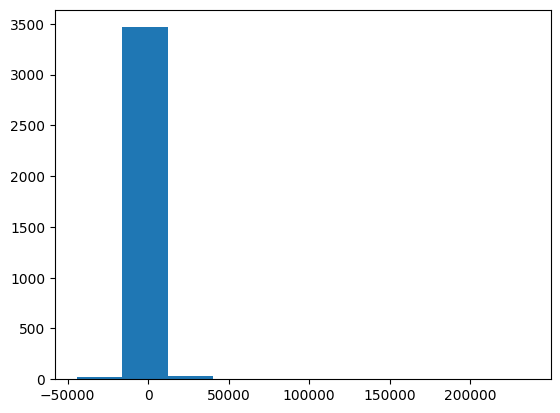

In [100]:
plt.hist(data-preds)

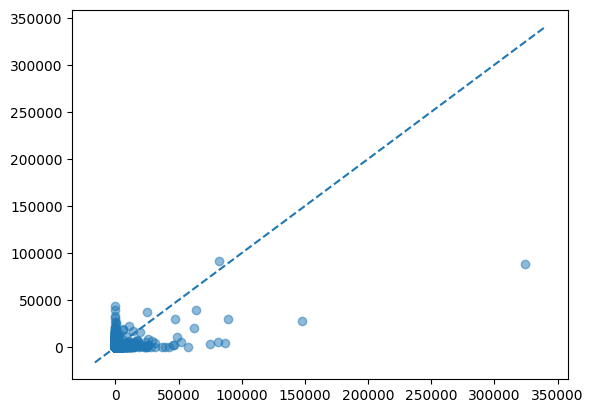

In [101]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(data,preds,alpha=0.5)
axes = plt.gca()
#axes.set_xlim([-10,350000])
#axes.set_ylim([-10,350000])
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
abline(1,0)

In [ ]:
0.83439332,1.02912974,0.98879558,-10